In [1]:
import pandas as pd
import numpy as np

In [2]:
import pandas_datareader.data as web
import datetime

In [3]:
start = datetime.datetime(2003,5,23)
end = datetime.datetime(2015,12,31)

In [4]:
# 주식 데이터 호출
code_name = '^GSPC'
code = web.DataReader(code_name, "yahoo", start, end)
code

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2003-05-23,935.200012,927.419983,931.869995,933.219971,1201000000,933.219971
2003-05-27,952.760010,927.330017,933.219971,951.479980,1532000000,951.479980
2003-05-28,959.390015,950.119995,951.479980,953.219971,1559000000,953.219971
2003-05-29,962.080017,946.229980,953.219971,949.640015,1685800000,949.640015
2003-05-30,965.380005,949.640015,949.640015,963.590027,1688800000,963.590027
...,...,...,...,...,...,...
2015-12-24,2067.360107,2058.729980,2063.520020,2060.989990,1411860000,2060.989990
2015-12-28,2057.770020,2044.199951,2057.770020,2056.500000,2492510000,2056.500000
2015-12-29,2081.560059,2060.540039,2060.540039,2078.360107,2542000000,2078.360107


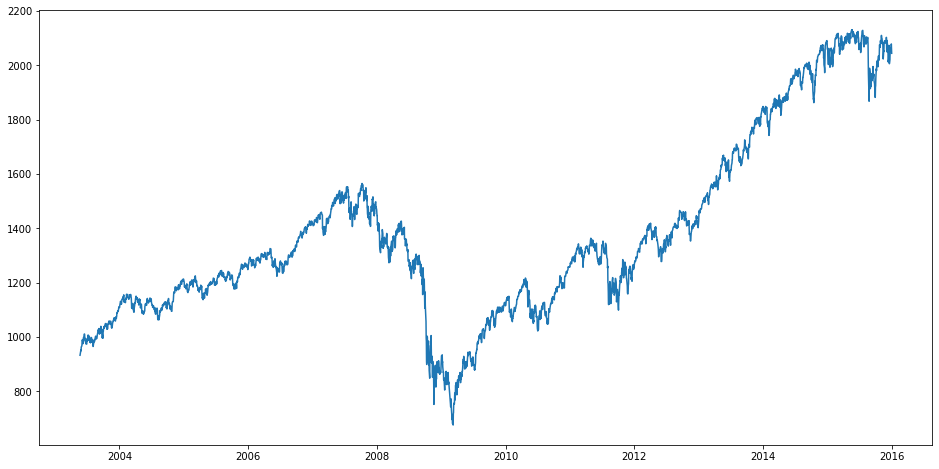

In [6]:
# plot stock
import matplotlib.pyplot as plt

plt.figure(figsize = (16,8) )
plt.plot(code['Close'])

In [7]:
data = code.filter(['Close']).values

In [8]:
from sklearn.preprocessing import MinMaxScaler

In [9]:
# Scale Close price to 0-1 values
scalar = MinMaxScaler(feature_range=(0,1))
scaled_data = scalar.fit_transform(data)
scaled_data

array([[0.17650533],
       [0.18906129],
       [0.19025774],
       ...,
       [0.96392744],
       [0.95361313],
       [0.94025942]])

In [10]:
# train data length
import math
training_data_len = math.ceil(len(scaled_data)* 0.8)

In [11]:
# set train data
train_data = scaled_data[0:training_data_len]
train_data

array([[0.17650533],
       [0.18906129],
       [0.19025774],
       ...,
       [0.62979186],
       [0.61649321],
       [0.62676631]])

In [12]:
# Append Past_set to x_train
x_train = []
y_train = []

PAST_SET = 10

for i in range(PAST_SET, len(train_data)):
  x_train.append(train_data[i-PAST_SET:i,0])
  y_train.append(train_data[i,0])

In [13]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [14]:
#LSTM needs to get 3d shape
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))

In [16]:
x_train.shape

(2530, 10, 1)

In [17]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [18]:
x_train.shape[1]

10

In [22]:
# Model
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (x_train.shape[1],1)))
model.add(LSTM(50, return_sequences = False))
model.add(Dense(25))
model.add(Dense(1))

In [23]:
model.compile(optimizer='adam', loss = 'mean_squared_error')

In [25]:
# Train
model.fit(x_train, y_train, batch_size = 1, epochs = 3 )

Epoch 1/3
2530/2530 [==============================] - 28s 4ms/step - loss: 0.0022
Epoch 2/3
2530/2530 [==============================] - 11s 4ms/step - loss: 4.4413e-04
Epoch 3/3
2530/2530 [==============================] - 11s 4ms/step - loss: 2.7549e-04


In [26]:
test_data = scaled_data[training_data_len - PAST_SET:, :]

x_test = []
y_test = data[training_data_len:, :]
for i in range(PAST_SET, len(test_data)) :
  x_test.append(test_data[i-PAST_SET:i,0])

In [27]:
x_test = np.array(x_test)

In [28]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [29]:
predictions = model.predict(x_test)
# un scaling
predictions = scalar.inverse_transform(predictions)

In [30]:
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

7.606342658095472

In [31]:
data = code.filter(['Close'])
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [32]:
valid

,Close,Predictions
Date,,
2013-06-26,1603.260010,1596.440430
2013-06-27,1613.199951,1611.829712
2013-06-28,1606.280029,1622.697876
2013-07-01,1614.959961,1618.845337
2013-07-02,1614.079956,1620.977905
...,...,...
2015-12-24,2060.989990,2067.957764
2015-12-28,2056.500000,2069.832031
2015-12-29,2078.360107,2064.779541


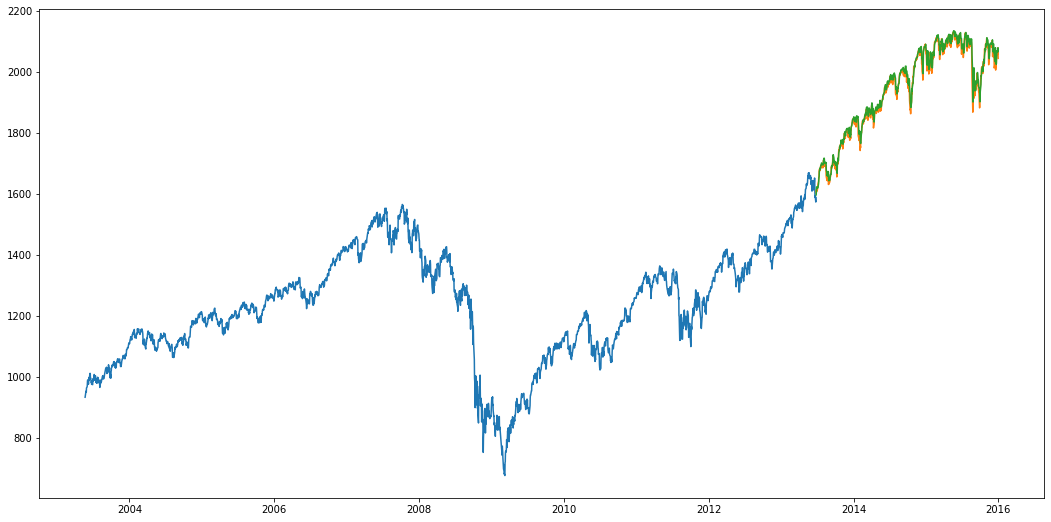

In [33]:
plt.figure(figsize=(18,9))
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Unrecognized location 'low'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  This is separate from the ipykernel package so we can avoid doing imports until


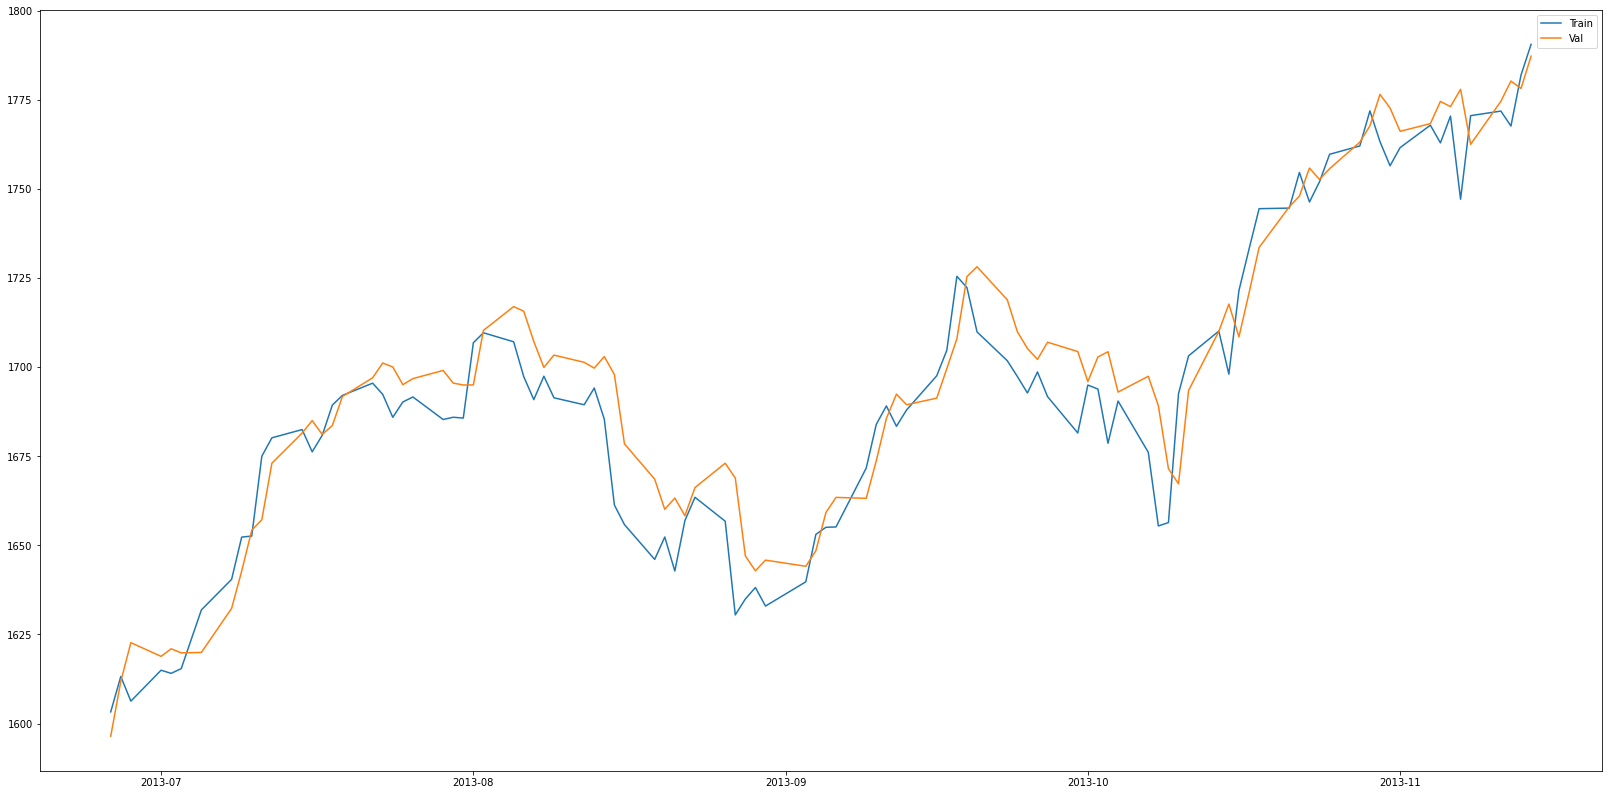

In [34]:
plt.figure(figsize=(28,14))
plt.plot(valid[['Close', 'Predictions']][:100])
plt.legend(['Train', 'Val', 'Predictions'], loc='low')